In [2]:
import pandas as pd
import numpy as np

from iminuit import Minuit

import matplotlib.pyplot as plt

# reproducible seed
np.random.seed(1234)

In [3]:
# import data from file
file = "code\1-Fragment_C_Hole_Measurements.csv"

# read csv 
df = pd.read_csv(file)

# just extract ID, X,Y values
data_col = df[["Section ID", "Mean(X)", "Mean(Y)"]]

jax_array = np.array(data_col)

# First index for ID, second index for X (1) or Y (2)
X = jax_array[:,1]
Y = jax_array[:,2]

data = [X,Y]

In [4]:
sizes = [1,22,9,37,1,3,2,6] # no. points in each section
def modelxy(N,R, a0,a1,a2,a3,a4,a5,a6,a7, xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7):
    
    xc = [xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7]
    yc = [yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7]
    a = [a0,a1,a2,a3,a4,a5,a6,a7]

    # duplicate values of xc, yc, alpha, to make array of length 81 (matching no. points) with values corresponding to each section
    # this is equivalent to iterating over [i] which doesn't work in this JAX-numpyro format

    xc_expand = np.array([val for val, count in zip(xc, sizes) for _ in range(count)])
    yc_expand = np.array([val for val, count in zip(yc, sizes) for _ in range(count)])
    a_expand = np.array([val for val, count in zip(a, sizes) for _ in range(count)])
    
    # index points 1-81 with i = [0,80]
    index = np.linspace(0,80,81)

    # phase offset for each point from start of its section
    phi = 2 * np.pi * index/N  +  (a_expand * np.pi/180) # degrees --> radians

    # model (x,y) coordinates
    xi = (R * np.cos(phi) + xc_expand)
    yi = (R * np.sin(phi) + yc_expand)
    

    return xi,yi, phi


In [5]:
def nll_isotropic(params):

    # unpack parameters:
    N,R, a0,a1,a2,a3,a4,a5,a6,a7,sigma, xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7 = params # note sigma_x = sigma_y so just one error parameter

    # unpack data
    X, Y = data

    # extract model xi,yi

    xi, yi, phi = modelxy(N,R, a0,a1,a2,a3,a4,a5,a6,a7, xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7)

    # likelihood on x & y

    x_likelihood = - np.sum((xi - X)**2 / (2 * sigma**2))
    y_likelihood = - np.sum((yi - Y)**2 / (2 * sigma**2))

    # prefactor
    norm = - len(X) * np.log(2 * np.pi * sigma * sigma)

    # total likelihood

    likelihood_isotropic = norm + np.sum(x_likelihood + y_likelihood)

    return likelihood_isotropic

In [6]:
# negative log likelihood function for aligned model

def nll_aligned(params):

    # unpack parameters:
    N,R, a0,a1,a2,a3,a4,a5,a6,a7,sigma_r, sigma_t, xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7 = params # note sigma_r =! sigma_t ONE MORE ERROR PARAMETER HERE

    # unpack data
    X, Y = data

    # extract model xi,yi

    xi, yi, phi = modelxy(N,R, a0,a1,a2,a3,a4,a5,a6,a7, xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7)

    # determine error between data & model (easier to do before coordinate shift)

    e_x = xi - X 
    e_y = yi - Y

    # project error into radial & tangential directions with coordinate transform depending on phi values
    r_p = e_x * np.cos(phi) + e_y * np.sin(phi)
    t_p = e_x * np.sin(phi) - e_y * np.cos(phi)

    # likelihood on radial & tangential components (errors independent so sum is separable)

    r_likelihood = - np.sum(r_p**2 / (2 * sigma_r**2))
    t_likelihood = - np.sum(t_p**2 / (2 * sigma_t**2))

    # prefactor
    norm = - len(X) * np.log(2 * np.pi * sigma_r*sigma_t)

    # total likelihood

    likelihood_aligned = norm + r_likelihood + t_likelihood

    return likelihood_aligned



    

In [7]:
# initial guesses CLOSE to final values 

isotropic_pars = [np.float32(355.59106),
 np.float32(77.41861),
 np.float32(-145.97374),
 np.float32(-145.6907),
 np.float32(-145.62646),
 np.float32(-145.49423),
 np.float32(-145.02866),
 np.float32(-146.24258),
 np.float32(-145.21626),
 np.float32(-147.69388),
 np.float32(0.09445262),
 np.float32(79.78643),
 np.float32(79.73406),
 np.float32(79.93495),
 np.float32(79.87209),
 np.float32(79.26972),
 np.float32(80.849236),
 np.float32(80.17723),
 np.float32(83.15083),
 np.float32(135.93518),
 np.float32(136.1171),
 np.float32(135.79169),
 np.float32(135.78033),
 np.float32(135.49957),
 np.float32(135.96243),
 np.float32(135.39807),
 np.float32(136.45322)]
anisotropic_pars = [np.float32(355.17987),
 np.float32(77.32409),
 np.float32(-145.8693),
 np.float32(-145.72342),
 np.float32(-145.67633),
 np.float32(-145.54785),
 np.float32(-144.87625),
 np.float32(-146.71133),
 np.float32(-146.29553),
 np.float32(-147.81609),
 np.float32(0.028512582),
 np.float32(0.1302617),
 np.float32(79.623215),
 np.float32(79.67909),
 np.float32(79.90056),
 np.float32(79.85814),
 np.float32(79.027725),
 np.float32(81.42486),
 np.float32(81.47354),
 np.float32(83.218414),
 np.float32(135.9855),
 np.float32(136.02188),
 np.float32(135.70462),
 np.float32(135.69351),
 np.float32(135.36047),
 np.float32(136.07745),
 np.float32(135.8094),
 np.float32(136.40288)]

In [8]:
# define functions to be taken in by Minuit

def n2ll_iso(pars):

    return -nll_isotropic(pars)

def n2ll_aligned(pars):

    return - nll_aligned(pars)


In [9]:
# use iminuit to minimize ALL parameters simultaneously for isotropic model

mi_iso = Minuit(n2ll_iso, isotropic_pars)
mi_iso.migrad()
mi_iso.hesse()
n2ll_min_iso = mi_iso.fval

In [10]:
# maximum likelihood parameters for isotropic model

mi_iso

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -165.3                     │             Nfcn = 2334              │
│ EDM = 3.09e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   355.3   │    0.7    │            │            │         │         │       │
│ 1 │ x1   │   77.34   │   0.14    │            │            │         │         │       │
│ 2 │ x2   │  -146.0   │    1.2    │            │            │         │         │       │
│ 3 │ x3   │  -145.70  │   0.14    │            │            │         │         │       │
│ 4 │ x4   │  -145.67  │   0.34    │            │            │         │         │       │
│ 5 │ x5   │  -145.54  │   0.12    │            │            │         │         │       │
│ 6 │ x6   │  -145.0   │    1.2    │            │            │         │         │       │
│ 7 │ x7   │  -146.7   │    0.7    │            │            │         │         │       │
│ 8 │ x8   │  -146.3   │    0.8    │            │            │         │         │       │
│ 9 │ x9   │  -147.8   │    0.5    │            │            │         │         │       │
│ 10│ x10  │   0.087   │   0.007   │            │            │         │         │       │
│ 11│ x11  │   79.7    │    0.9    │            │            │         │         │       │
│ 12│ x12  │   79.69   │   0.17    │            │            │         │         │       │
│ 13│ x13  │   79.9    │    0.4    │            │            │         │         │       │
│ 14│ x14  │   79.87   │   0.10    │            │            │         │         │       │
│ 15│ x15  │   79.3    │    1.5    │            │            │         │         │       │
│ 16│ x16  │   81.5    │    0.9    │            │            │         │         │       │
│ 17│ x17  │   81.5    │    1.1    │            │            │         │         │       │
│ 18│ x18  │   83.2    │    0.6    │            │            │         │         │       │
│ 19│ x19  │   135.9   │    1.3    │            │            │         │         │       │
│ 20│ x20  │  136.06   │   0.17    │            │            │         │         │       │
│ 21│ x21  │  135.72   │   0.25    │            │            │         │         │       │
│ 22│ x22  │  135.71   │   0.15    │            │            │         │         │       │
│ 23│ x23  │   135.5   │    0.5    │            │            │         │         │       │
│ 24│ x24  │  136.13   │   0.29    │            │            │         │         │       │
│ 25│ x25  │   135.8   │    0.4    │            │            │         │         │       │
│ 26│ x26  │  136.42   │   0.27    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │       

In [11]:
    # look for highly correlated features

print(mi_iso.covariance.correlation())  # Look for near ±1 correlations

┌─────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │   x0   x1   x2   x3   x4   x5   x6   x7   x8   x9  x10  x11  x12  x13  x14  x15  x16  x17  x18  x19  x20  x21  x22  x23  x24  x25  x26 │
├─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │    1  0.8    0  0.1  0.1  0.8  0.1  0.1  0.1  0.2    0  0.1  0.5  0.2  0.2    0  0.1  0.1  0.1    0  0.5  0.4  0.8  0.3  0.5  0.4  0.5 │
│  x1 │  0.8    1    0  0.1  0.1  0.6    0  0.1  0.1  0.2    0  0.1  0.6  0.2  0.2    0    0    0    0  0.1  0.6  0.5    1  0.3  0.5  0.4  0.6 │
│  x2 │    0    0    1    0    0    0    0    0    0    0    0   -1    0    0    0    0    0    0    0    1    0    0    0    0    0    0    0 │
│  x3 │  0.1  0.1    0    1    0  0.1    0    0    0    0    0    0 -0.7    0    0    0    0    0    0    0  0.8    0  0.1    0  0

In [12]:
# use iminuit to minimize ALL parameters simultaneously for radial-tangential model

mi_ali = Minuit(n2ll_aligned, anisotropic_pars)
mi_ali.migrad()
mi_ali.hesse()
n2ll_min_ali = mi_ali.fval

In [13]:
# Maximum likelihood predictions for radial-tangential model

mi_ali

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -238.5                     │             Nfcn = 2056              │
│ EDM = 8.74e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   355.2   │    0.6    │            │            │         │         │       │
│ 1 │ x1   │   77.33   │   0.06    │            │            │         │         │       │
│ 2 │ x2   │  -145.9   │    0.7    │            │            │         │         │       │
│ 3 │ x3   │  -145.72  │   0.06    │            │            │         │         │       │
│ 4 │ x4   │  -145.67  │   0.17    │            │            │         │         │       │
│ 5 │ x5   │  -145.54  │   0.09    │            │            │         │         │       │
│ 6 │ x6   │  -144.9   │    1.1    │            │            │         │         │       │
│ 7 │ x7   │  -146.7   │    0.6    │            │            │         │         │       │
│ 8 │ x8   │  -146.3   │    0.7    │            │            │         │         │       │
│ 9 │ x9   │  -147.81  │   0.30    │            │            │         │         │       │
│ 10│ x10  │  0.0254   │  0.0028   │            │            │         │         │       │
│ 11│ x11  │   0.121   │   0.013   │            │            │         │         │       │
│ 12│ x12  │   79.6    │    0.6    │            │            │         │         │       │
│ 13│ x13  │   79.69   │   0.06    │            │            │         │         │       │
│ 14│ x14  │   79.90   │   0.19    │            │            │         │         │       │
│ 15│ x15  │  79.859   │   0.032   │            │            │         │         │       │
│ 16│ x16  │   79.0    │    1.5    │            │            │         │         │       │
│ 17│ x17  │   81.5    │    0.7    │            │            │         │         │       │
│ 18│ x18  │   81.5    │    0.9    │            │            │         │         │       │
│ 19│ x19  │   83.22   │   0.34    │            │            │         │         │       │
│ 20│ x20  │   136.0   │    0.8    │            │            │         │         │       │
│ 21│ x21  │  136.03   │   0.06    │            │            │         │         │       │
│ 22│ x22  │  135.71   │   0.11    │            │            │         │         │       │
│ 23│ x23  │  135.70   │   0.06    │            │            │         │         │       │
│ 24│ x24  │   135.4   │    0.4    │            │            │         │         │       │
│ 25│ x25  │   136.1   │    0.2    │            │            │         │         │       │
│ 26│ x26  │  135.84   │   0.29    │            │            │         │         │       │
│ 27│ x27  │  136.41   │   0.14    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [15]:
# look for highly correlated features

print(mi_ali.covariance.correlation())  # Look for near ±1 correlations

┌─────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │   x0   x1   x2   x3   x4   x5   x6   x7   x8   x9  x10  x11  x12  x13  x14  x15  x16  x17  x18  x19  x20  x21  x22  x23  x24  x25  x26  x27 │
├─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │    1  0.4    0  0.3  0.3  0.9  0.1  0.2  0.2  0.4    0    0    0  0.2  0.1  0.1    0    0    0    0    0  0.2  0.1  0.4  0.1  0.1  0.1  0.2 │
│  x1 │  0.4    1    0  0.1  0.1  0.3  0.1  0.1  0.1  0.2    0    0  0.1  0.7  0.2  0.2    0 -0.1 -0.1 -0.1  0.1  0.7  0.4    1  0.1  0.2  0.1  0.3 │
│  x2 │    0    0    1    0    0    0    0    0    0    0    0    0   -1    0    0    0    0    0    0    0    1    0    0    0    0    0    0    0 │
│  x3 │  0.3  0.1    0    1  0.1  0.3    0  0.1  0.1  0.1    0    0    0 -0.5    0    0    0    0   

In [16]:
# extract parameter maximum likelihood values & errors and pass them through the model

sizes = [1,22,9,37,1,3,2,6] # no. points in each section

# explicitly require separate parameters for xc0,xc1,xc2 etc...

def modelxy(N,R, a0,a1,a2,a3,a4,a5,a6,a7,sigma, xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7):
    
    xc = [xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7]
    yc = [yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7]
    a = [a0,a1,a2,a3,a4,a5,a6,a7]

    # duplicate values of xc, yc, alpha, to make array of length 81 (matching no. points) with values corresponding to each section
    # this is equivalent to iterating over [i] which doesn't work in this JAX-numpyro format

    xc_expand = np.array([val for val, count in zip(xc, sizes) for _ in range(count)])
    yc_expand = np.array([val for val, count in zip(yc, sizes) for _ in range(count)])
    a_expand = np.array([val for val, count in zip(a, sizes) for _ in range(count)])
    
    # index points 1-81 with i = [0,80]
    index = np.linspace(0,80,81)

    # phase offset for each point from start of its section
    phi = 2 * np.pi * index/N  +  (a_expand * np.pi/180) # degrees --> radians

    # model (x,y) coordinates
    xi = (R * np.cos(phi) + xc_expand)
    yi = (R * np.sin(phi) + yc_expand)
    

    return xi,yi,phi



ml_isotropic = mi_iso.values[:]
ml_isotropic_err = mi_iso.errors[:]
print(ml_isotropic)
isotropic_ml = modelxy(*ml_isotropic)

ml_aligned = mi_ali.values[:]
ml_aligned_err = mi_ali.errors[:]
ml_aligned.pop(10)
aligned_ml = modelxy(*ml_aligned)
ml_aligned = mi_ali.values[:]

[355.2577814317212, 77.34395004641385, -145.97338143230755, -145.70237391313623, -145.66714494950944, -145.54225515516555, -145.04847398160297, -146.74948356009892, -146.294255474965, -147.79338460586027, 0.08723704444963883, 79.7002410217738, 79.6861065413035, 79.90536877867034, 79.86768021131734, 79.25157018653482, 81.49808411630198, 81.48032594297112, 83.2100066050591, 135.87649587042088, 136.06372844940466, 135.72315341549654, 135.70585644989254, 135.46258251798795, 136.12573594178485, 135.83743309357413, 136.42116387742936]
[355.214680398532, 77.33115156254726, -145.8764248545134, -145.72215429120305, -145.67413486324378, -145.54259699467573, -144.85672186681234, -146.72074531395577, -146.3409583206586, -147.80743298936594, 0.1210529218974264, 79.6163198283151, 79.68554208621275, 79.90431037768971, 79.8592246858633, 78.99377134054416, 81.45277888938111, 81.53242418440007, 83.21917300278494, 135.9777368215063, 136.0268802518819, 135.71043454838764, 135.70120525654517, 135.380375187

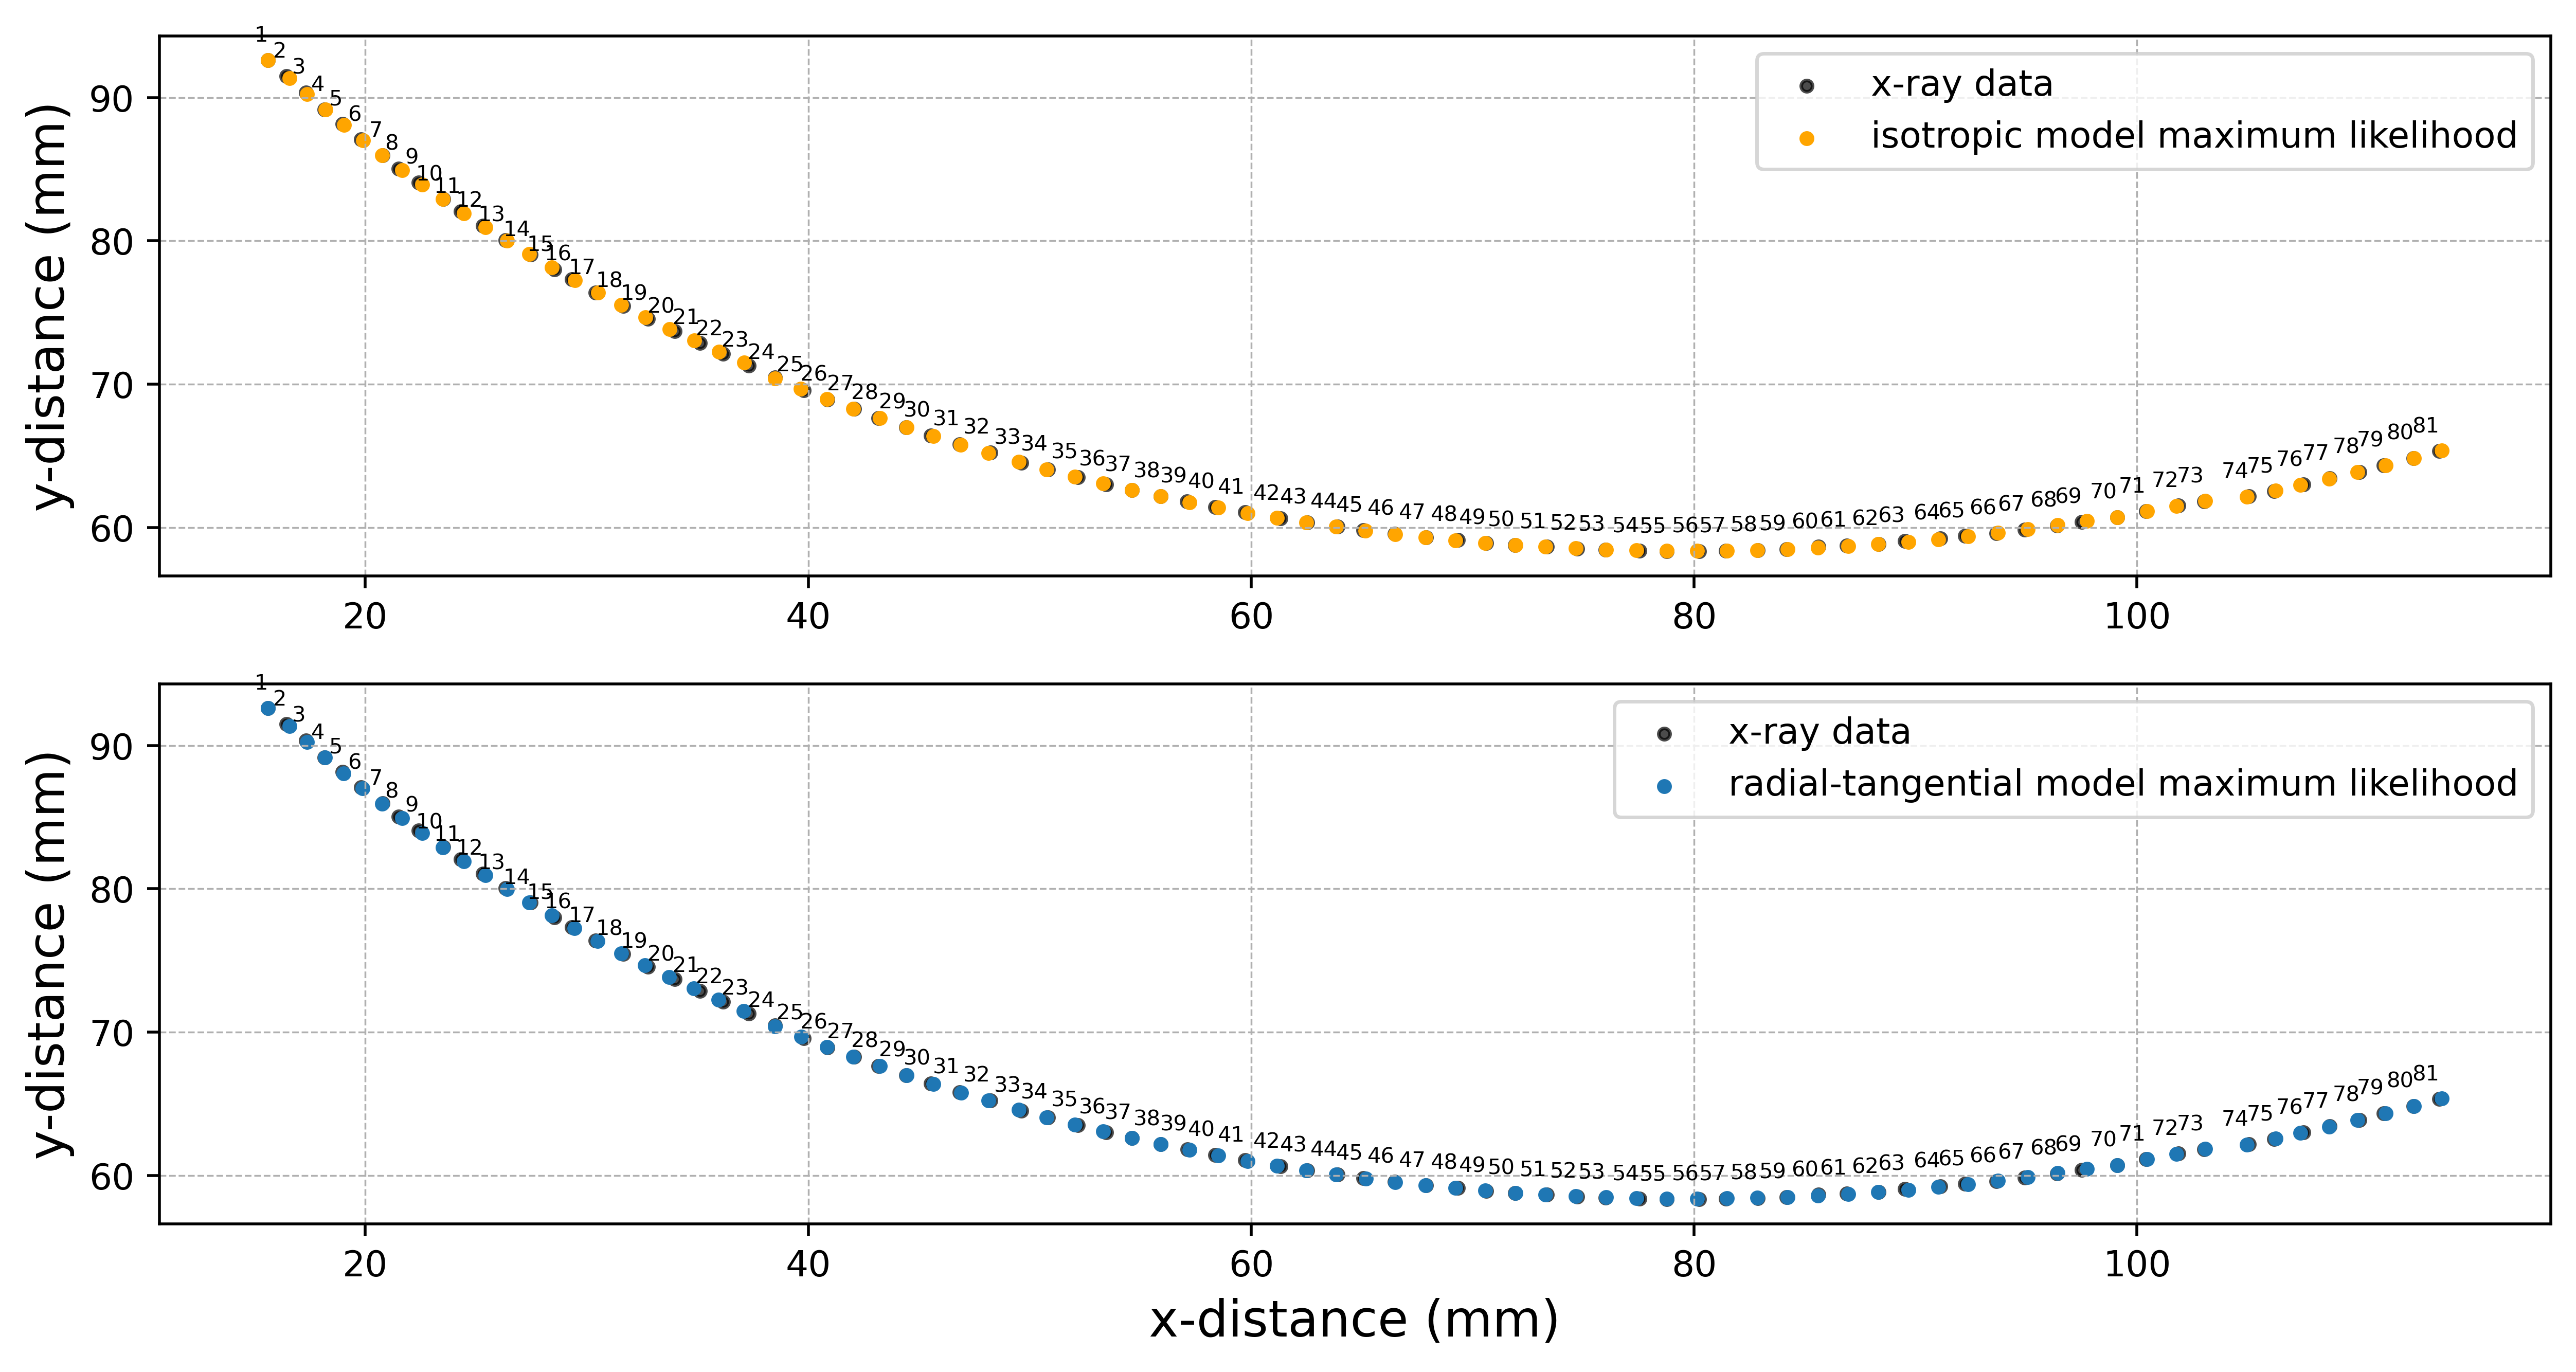

In [17]:
# Colourblind distinguishable colours (works for me)
tableau20 = ['#332288', '#88CCEE', '#117733', '#DDCC77', '#CC6677', '#AA4499', '#44AA99', '#999933', '#882255', '#661100', '#6699CC', '#AA4466']

# Create the plot
fig,axes = plt.subplots(2,1, figsize=(12,6))

fig.set_dpi(300)

axes[0].scatter(X, Y, c='black', edgecolor='black', alpha=0.7, s=10, label='x-ray data')  # Pretty scatterplot
axes[1].scatter(X, Y, c='black', edgecolor='black', alpha=0.7, s=10, label='x-ray data')
axes[0].scatter(isotropic_ml[0], isotropic_ml[1], alpha=1, s=10, label='isotropic model maximum likelihood', color ='orange')
axes[1].scatter(aligned_ml[0], aligned_ml[1], alpha=1, s=10, label='radial-tangential model maximum likelihood')

# Label each point with its index (1 to 81)
for i in range(81):
    axes[0].text(X[i], Y[i]+1, str(i+1), fontsize=6, ha='right', va='bottom',)
    axes[1].text(X[i], Y[i]+1, str(i+1), fontsize=6, ha='right', va='bottom',)



# Customize labels and title
axes[1].set_xlabel('x-distance (mm)', fontsize=14)

axes[0].set_ylabel('y-distance (mm)', fontsize=14)
axes[1].set_ylabel('y-distance (mm)', fontsize=14)


# Add a grid and adjust appearance
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

axes[0].legend()
axes[1].legend()

fig.set_dpi(500)

# Show the plot
plt.show()

In [ ]:
# error propagation

# requires partial derivatives of the model wrt parameters

# propagate with dx/dtheta and dy/dtheta

# propagate via std_x_squared = (dx/dxj * std_xj) ** 2 + (dx/dr * std_r)**2 + ...

def error_prop_iso(N,R,Ne,Re, a0e,a1e,a2e,a3e,a4e,a5e,a6e,a7e, sigma, xc0e,xc1e,xc2e,xc3e,xc4e,xc5e,xc6e,xc7e,yc0e,yc1e,yc2e,yc3e,yc4e,yc5e,yc6e,yc7e):

    dx_dxj = 1
    dy_dyj = 1

    std_x_2 = []
    std_y_2 = []

    xce = [xc0e,xc1e,xc2e,xc3e,xc4e,xc5e,xc6e,xc7e]
    yce = [yc0e,yc1e,yc2e,yc3e,yc4e,yc5e,yc6e,yc7e]
    ae = [a0e,a1e,a2e,a3e,a4e,a5e,a6e,a7e]

    xce_expand = np.array([val for val, count in zip(xce, sizes) for _ in range(count)])
    yce_expand = np.array([val for val, count in zip(yce, sizes) for _ in range(count)])
    ae_expand = np.array([val for val, count in zip(ae, sizes) for _ in range(count)])

    linear = np.linspace(1,81,81)

    dx_dr = np.cos(isotropic_ml[2])
    dy_dr = np.sin(isotropic_ml[2])

    dx_dN = -R * np.sin(isotropic_ml[2]) * 2*np.pi*(linear)/N**2
    dy_dN = R * np.cos(isotropic_ml[2]) * 2*np.pi*(linear)/N**2 

    dx_dalpha = -R * np.sin(isotropic_ml[2]) * np.pi/180
    dy_dalpha = R * np.cos(isotropic_ml[2]) * np.pi/180

    std_x_2_temp = (dx_dxj * xce_expand) **2 + (dx_dr * Re) **2  + (dx_dalpha * ae_expand)**2  + (dx_dN * Ne)**2 
    std_y_2_temp = (dy_dyj * yce_expand) ** 2 + (dy_dr * Re) ** 2 + (dy_dalpha * ae_expand) **2 + (dy_dN * Ne) ** 2
  
    std_x_2.append(std_x_2_temp)
    std_y_2.append(std_y_2_temp)

    
    return np.sqrt(std_x_2), np.sqrt(std_y_2)

def error_prop_ali(N,R,Ne,Re, a0e,a1e,a2e,a3e,a4e,a5e,a6e,a7e, sigma_r,sigma_t, xc0e,xc1e,xc2e,xc3e,xc4e,xc5e,xc6e,xc7e,yc0e,yc1e,yc2e,yc3e,yc4e,yc5e,yc6e,yc7e):

    dx_dxj = 1
    dy_dyj = 1

    std_x_2 = []
    std_y_2 = []

    xce = [xc0e,xc1e,xc2e,xc3e,xc4e,xc5e,xc6e,xc7e]
    yce = [yc0e,yc1e,yc2e,yc3e,yc4e,yc5e,yc6e,yc7e]
    ae = [a0e,a1e,a2e,a3e,a4e,a5e,a6e,a7e]

    xce_expand = np.array([val for val, count in zip(xce, sizes) for _ in range(count)])
    yce_expand = np.array([val for val, count in zip(yce, sizes) for _ in range(count)])
    ae_expand = np.array([val for val, count in zip(ae, sizes) for _ in range(count)])

    linear = np.linspace(1,81,81)

    dx_dr = np.cos(aligned_ml[2])
    dy_dr = np.sin(aligned_ml[2])
 
    dx_dN = -R * np.sin(aligned_ml[2]) * 2*np.pi*(linear)/N**2
    dy_dN = R * np.cos(aligned_ml[2]) * 2*np.pi*(linear)/N**2

    dx_dalpha = -R * np.sin(aligned_ml[2]) * np.pi/180
    dy_dalpha = R * np.cos(aligned_ml[2])* np.pi/180
    
    std_x_2_temp = (dx_dxj * xce_expand) **2 + (dx_dr * Re) **2  + (dx_dalpha * ae_expand)**2  + (dx_dN * Ne)**2 
    std_y_2_temp = (dy_dyj * yce_expand) ** 2 + (dy_dr * Re) ** 2 + (dy_dalpha * ae_expand) **2 + (dy_dN * Ne) ** 2
 
    std_x_2.append(std_x_2_temp)
    std_y_2.append(std_y_2_temp)


    return np.sqrt(std_x_2), np.sqrt(std_y_2)

N_iso = ml_isotropic[0]
R_iso = ml_isotropic[1]

N_ali = ml_aligned[0]
R_ali = ml_aligned[1]

# find X and Y errors for both models

err_x_iso, err_y_iso = error_prop_iso(N_iso, R_iso, *ml_isotropic_err)

err_x_ali, err_y_ali = error_prop_ali(N_ali, R_ali, *ml_aligned_err)


In [91]:
# show positions of holes for each available section of the mechanism for section divisions

# X-Y measurements
X = df['Mean(X)']
Y = df['Mean(Y)']

# split dataset into 8 fractured sections grouped by section ID

sections = df.groupby("Section ID")

for i, section in sections:
    print(f"\nSection ID {i}:")
    print(section)   

# can extract each section with .get_group(ID)
section_0 = sections.get_group(0)
section_1 = sections.get_group(1)
section_2 = sections.get_group(2)
section_3 = sections.get_group(3)
section_4 = sections.get_group(4)
section_5 = sections.get_group(5)
section_6 = sections.get_group(6)
section_7 = sections.get_group(7)


Section ID 0:
   Section ID  Hole  Inter-hole Distance   Mean(X)   Mean(Y)
0           0     1                  NaN  15.59931  92.59653

Section ID 1:
    Section ID  Hole  Inter-hole Distance   Mean(X)   Mean(Y)
1            1     2                  NaN  16.44167  91.50069
2            1     3             1.440694  17.30764  90.34931
3            1     4             1.456973  18.15278  89.16250
4            1     5             1.299821  18.96528  88.14792
5            1     6             1.372859  19.81389  87.06875
6            1     7             1.468066  20.78611  85.96875
7            1     8             1.174471  21.49722  85.03403
8            1     9             1.318648  22.39931  84.07222
9            1    10             1.613049  23.51250  82.90486
10           1    11             1.175379  24.31250  82.04375
11           1    12             1.403037  25.31736  81.06458
12           1    13             1.423551  26.32083  80.05486
13           1    14             1.527462 

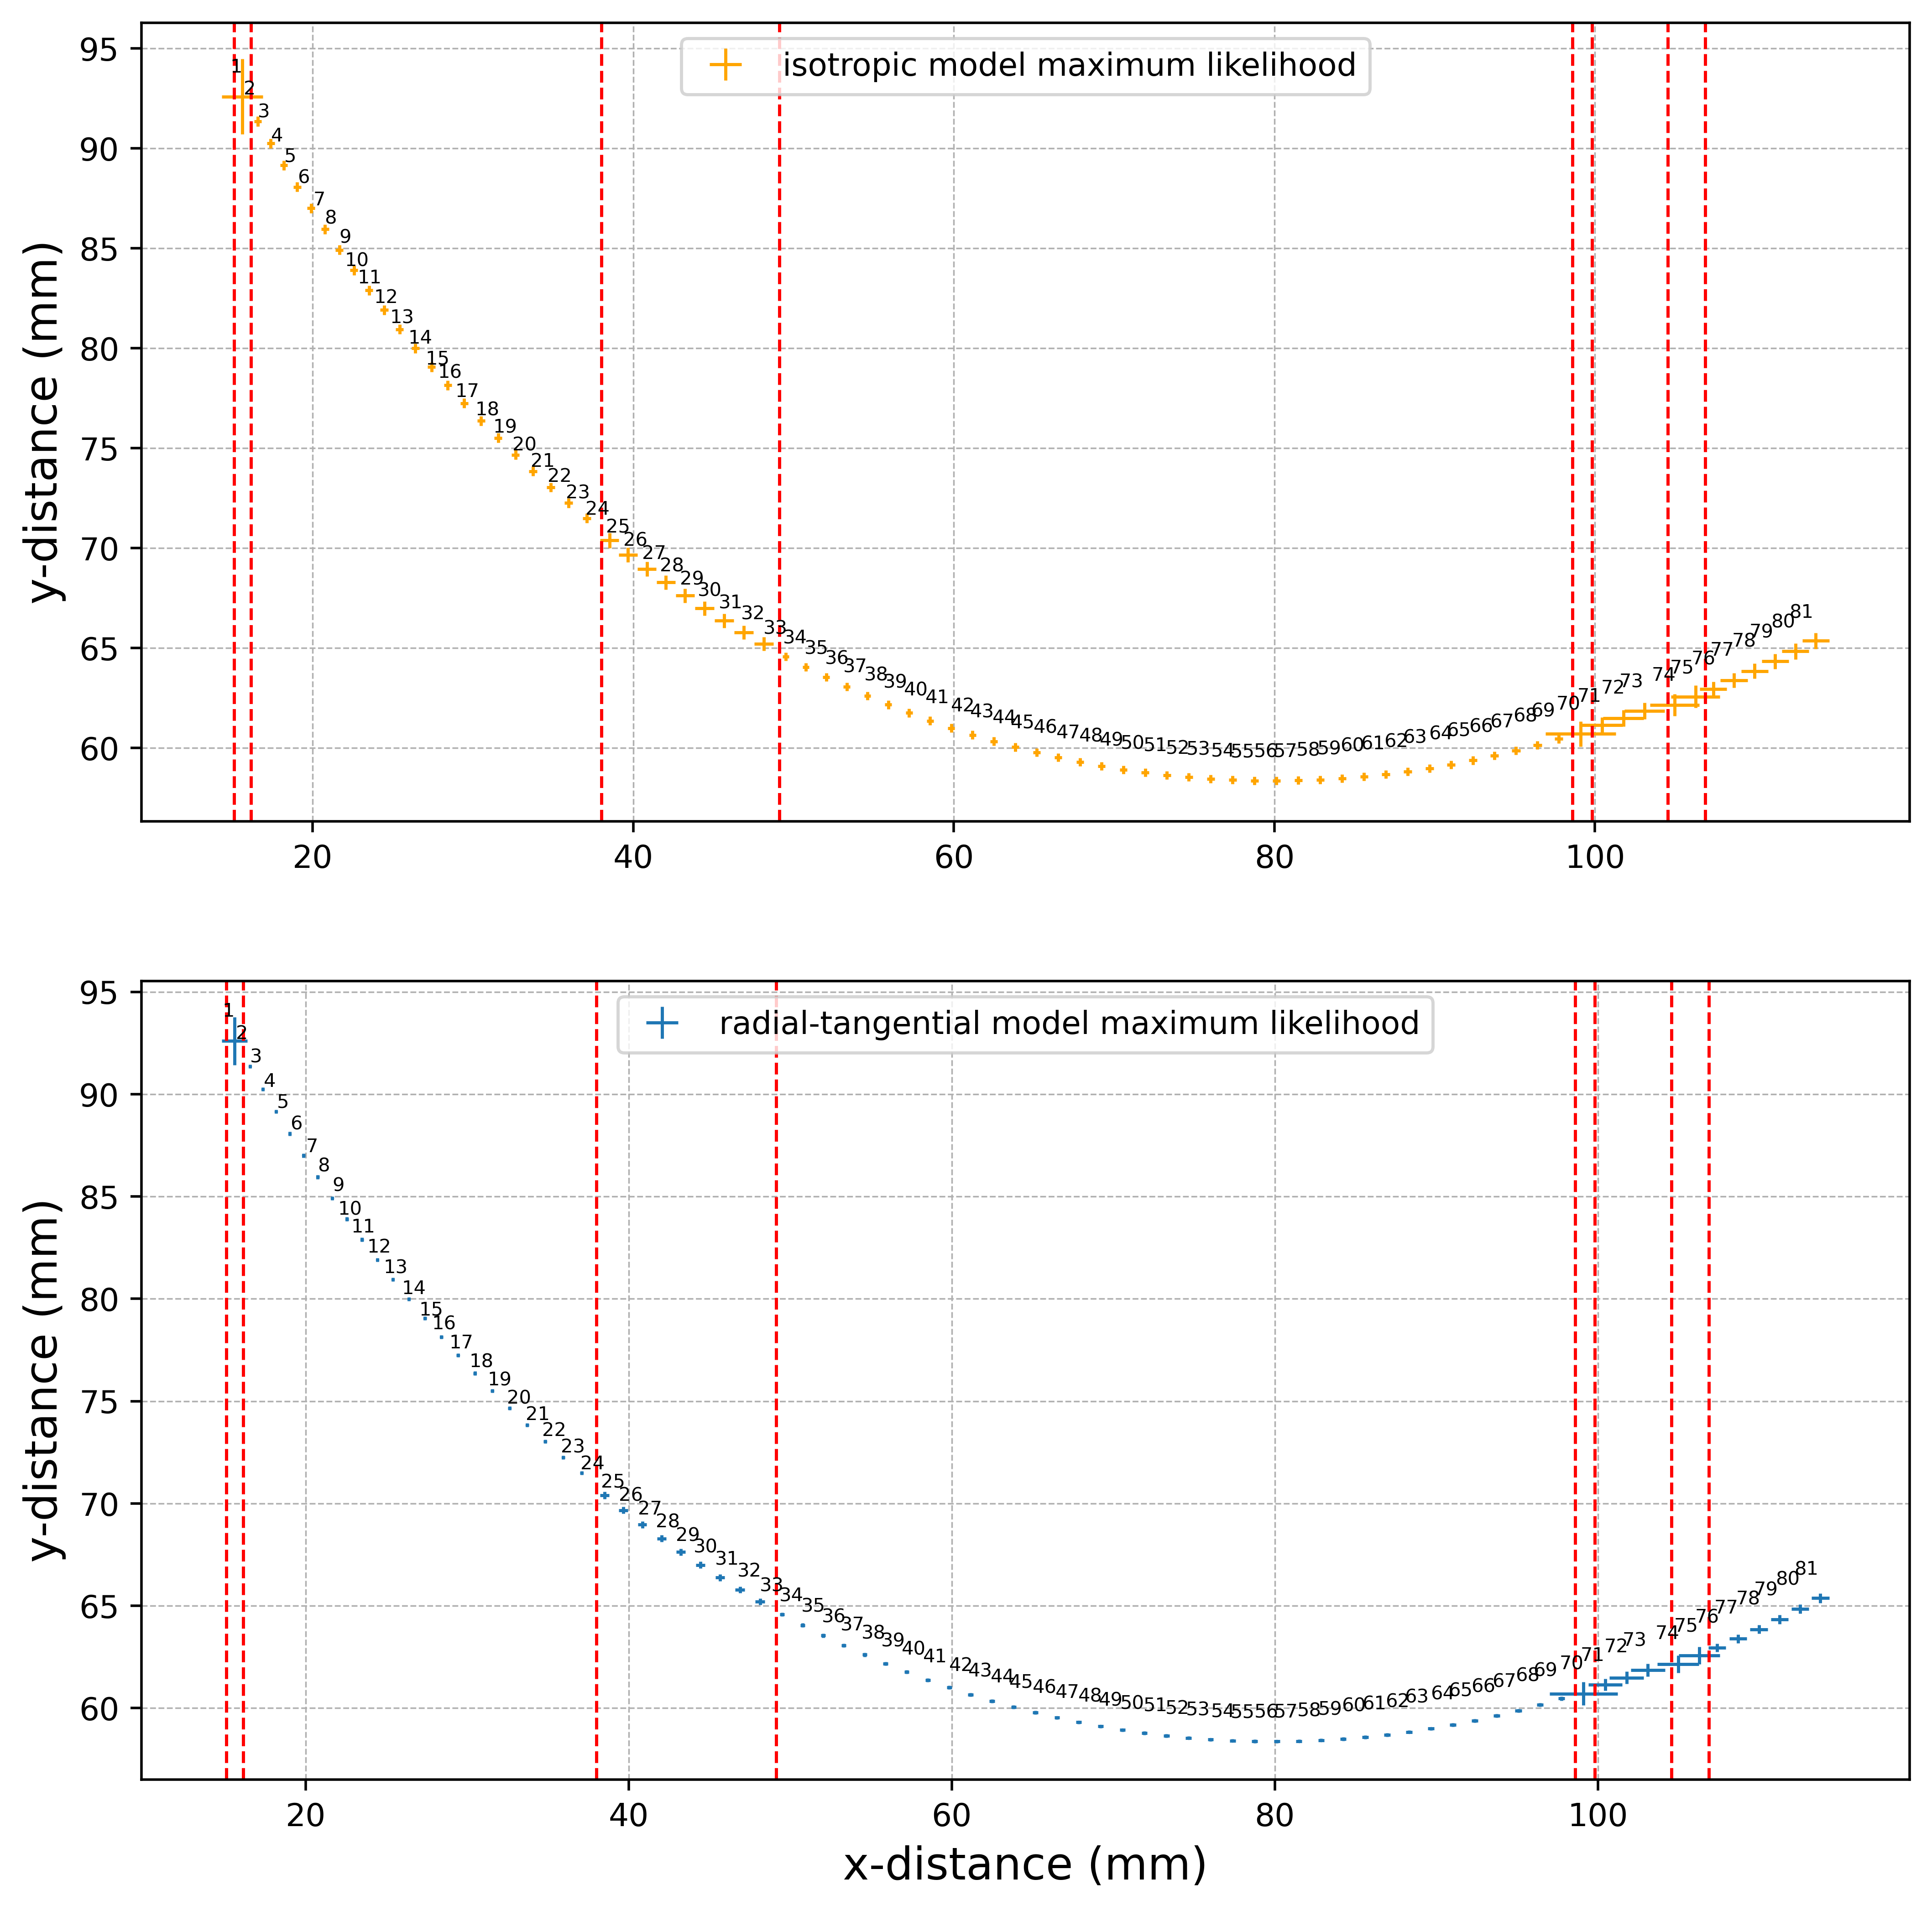

In [106]:
# Colourblind distinguishable colours (works for me)
tableau20 = ['#332288', '#88CCEE', '#117733', '#DDCC77', '#CC6677', '#AA4499', '#44AA99', '#999933', '#882255', '#661100', '#6699CC', '#AA4466']

# Create the plot
fig,axes = plt.subplots(2,1, figsize=(10,10))

fig.set_dpi(300)

axes[0].errorbar(isotropic_ml[0], isotropic_ml[1], xerr=err_x_iso, yerr=err_y_iso, fmt='o', elinewidth=1, markersize=0.1,label='isotropic model maximum likelihood', color ='orange')
axes[1].errorbar(aligned_ml[0], aligned_ml[1], xerr=err_x_ali, yerr=err_y_ali,alpha=1,fmt='o', elinewidth=1,markersize=0.1, label='radial-tangential model maximum likelihood')


# Label each point with its index (1 to 81)
for i in range(81):
    axes[0].text(X[i], Y[i]+1, str(i+1), fontsize=6, ha='right', va='bottom',)
    axes[1].text(X[i], Y[i]+1, str(i+1), fontsize=6, ha='right', va='bottom',)



# Customize labels and title
axes[1].set_xlabel('x-distance (mm)', fontsize=14)

axes[0].set_ylabel('y-distance (mm)', fontsize=14)
axes[1].set_ylabel('y-distance (mm)', fontsize=14)


axes[0].axvline(section_0['Mean(X)'][0]-0.5, color="red", linestyle="--", linewidth=1)
axes[0].axvline(section_1['Mean(X)'][1]-0.3, color="red", linestyle="--", linewidth=1)
axes[0].axvline(section_2['Mean(X)'][23]-0.5, color="red", linestyle="--", linewidth=1)
axes[0].axvline(section_3['Mean(X)'][32]-0.5, color="red", linestyle="--", linewidth=1)
axes[0].axvline(section_4['Mean(X)'][69]-0.5, color="red", linestyle="--", linewidth=1)
axes[0].axvline(section_5['Mean(X)'][70]-0.6, color="red", linestyle="--", linewidth=1)
axes[0].axvline(section_6['Mean(X)'][73]-0.5, color="red", linestyle="--", linewidth=1)
axes[0].axvline(section_7['Mean(X)'][75]-0.65, color="red", linestyle="--", linewidth=1)

axes[1].axvline(section_0['Mean(X)'][0]-0.5, color="red", linestyle="--", linewidth=1)
axes[1].axvline(section_1['Mean(X)'][1]-0.3, color="red", linestyle="--", linewidth=1)
axes[1].axvline(section_2['Mean(X)'][23]-0.5, color="red", linestyle="--", linewidth=1)
axes[1].axvline(section_3['Mean(X)'][32]-0.5, color="red", linestyle="--", linewidth=1)
axes[1].axvline(section_4['Mean(X)'][69]-0.5, color="red", linestyle="--", linewidth=1)
axes[1].axvline(section_5['Mean(X)'][70]-0.6, color="red", linestyle="--", linewidth=1)
axes[1].axvline(section_6['Mean(X)'][73]-0.5, color="red", linestyle="--", linewidth=1)
axes[1].axvline(section_7['Mean(X)'][75]-0.65, color="red", linestyle="--", linewidth=1)



# Add a grid and adjust appearance
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

axes[0].legend()
axes[1].legend()

fig.set_dpi(500)

# Show the plot
plt.show()

In [ ]:
# strictly negative --> aligned error < isotropic error for all holes

print(err_x_ali - err_x_iso)
print(err_y_ali - err_y_iso)

[[-0.49319539 -0.14916838 -0.14947687 -0.14977425 -0.15005864 -0.15032819
  -0.15058111 -0.15081568 -0.15103028 -0.15122337 -0.15139354 -0.15153949
  -0.15166006 -0.15175425 -0.15182119 -0.15186019 -0.15187072 -0.1518524
  -0.15180502 -0.15172853 -0.15162306 -0.15148884 -0.1513263  -0.30105186
  -0.30214448 -0.30320123 -0.30422093 -0.30520246 -0.30614478 -0.3070469
  -0.30790789 -0.30872689 -0.06471522 -0.0641814  -0.06367274 -0.06318944
  -0.06273164 -0.06229938 -0.06189267 -0.06151145 -0.06115558 -0.0608249
  -0.06051918 -0.06023813 -0.05998143 -0.05974872 -0.0595396  -0.05935363
  -0.05919034 -0.05904925 -0.05892983 -0.05883155 -0.05875386 -0.05869617
  -0.05865793 -0.05863852 -0.05863737 -0.05865388 -0.05868743 -0.05873745
  -0.05880332 -0.05888447 -0.0589803  -0.05909025 -0.05921375 -0.05935025
  -0.0594992  -0.0596601  -0.05983243 -0.0952409  -0.20852044 -0.20818232
  -0.20781995 -0.2475564  -0.24697468 -0.30225793 -0.30149643 -0.3007046
  -0.29988329 -0.29903337 -0.29815577]]
[[